In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import seaborn as sns
from src.political_party_analysis.loader import DataLoader
from src.political_party_analysis.dim_reducer import DimensionalityReducer
from src.political_party_analysis.visualization import scatter_plot, plot_density_estimation_results, plot_finnish_parties
from src.political_party_analysis.estimator import DensityEstimator

In [38]:
df_original= pd.read_stata('data/CHES2019V3.dta')
# df.head()
df_original.set_index(["party_id", "party", "country"], inplace=True)
df= df_original.copy()
# df.columns

In [39]:
# Identify duplicate rows
# duplicates = df[df.duplicated()]
df = df.drop_duplicates()
# print('Shape of df before and after removing duplicates: df_orginal.shape, df.shape')
print(f"Shape of DataFrame before and after removing duplicates: {df_original.shape}, {df.shape}")


Shape of DataFrame before and after removing duplicates: (277, 52), (277, 52)


In [40]:
# df.fillna(df.mean(), inplace=True)

def impute_numerical_columns_with_knn(df, n_neighbors=5):
    """
    Automatically finds all numerical columns in a DataFrame and imputes missing values
    using KNNImputer.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        n_neighbors (int): Number of neighbors to consider for KNNImputer.
        
    Returns:
        pd.DataFrame: A DataFrame with missing values in numerical columns imputed.
    """
    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns
    
    # Copy the DataFrame to avoid modifying the original
    df_imputed = df.copy()
    
    # Apply KNNImputer to numerical columns only
    if not numerical_cols.empty:
        imputer = KNNImputer(n_neighbors=n_neighbors)
        df_imputed[numerical_cols] = imputer.fit_transform(df_imputed[numerical_cols])
    
    return df_imputed

df= impute_numerical_columns_with_knn(df)

In [41]:
def scale_feat(df: pd.DataFrame) -> pd.DataFrame:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    return scaled_df

df= scale_feat(df)
# df['lrgen']= 10*df['lrgen']


In [42]:
# Reduce the data to 2D
dimensionality_red= DimensionalityReducer(data= df, model= None, n_components= 2)
reduced_data = dimensionality_red.reduce_to_2d()

    # Print the result
# print("Reduced Data:", reduced_data)

In [43]:
# scatter_plot(
#     transformed_data= df,    
#     color= 'y',
#     size= 10,
#     splot= None,
#     label= None)
# plt.show()

In [44]:
density_estimator= DensityEstimator(reduced_data)
kde_model = density_estimator.model_distribution(bandwidth= 0.1)
# Step 2: Randomly sample 10 parties
sampled_parties = density_estimator.sample_parties(kde_model, n_samples=10)
# print("Sampled Parties (Reduced Space):\n", sampled_parties)

# original_space= density_estimator.map_to_original_space(df)

In [45]:
def encode_continuous_to_classes(series, bins, labels=None):
    """
    Encodes a continuous variable into discrete classes.
    
    Parameters:
        series (pd.Series): The continuous variable to encode.
        bins (list): A list of bin edges. For example, [1, 4, 7, 10] creates three bins: 1-4, 4-7, and 7-10.
        labels (list, optional): A list of labels for the bins. If None, the bins are labeled with integers.
        
    Returns:
        pd.Series: A new series with the encoded classes.
    """
    if labels is None:
        labels = range(len(bins) - 1)
    return pd.cut(series, bins=bins, labels=labels, include_lowest=True)

# Define the bins and optional labels
# bins = [1, 4, 7, 10]  # 1-4, 4-7, 7-10
bins = [0.1, 0.4, 0.7, 10] 
labels = [1, 2, 3]

orientation= encode_continuous_to_classes(df['lrgen'], bins, labels= labels)
# print(orientation)


In [46]:
df['Orientation']= orientation
df= df.drop(['lrgen'], axis=1)

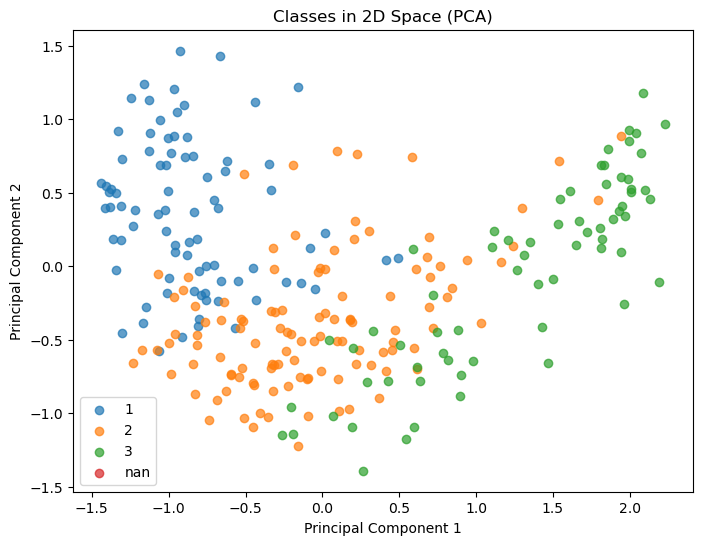

In [47]:
# Convert to DataFrame for plotting
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['class'] = orientation.values

# Plot the classes in 2D space
plt.figure(figsize=(8, 6))
for cls in reduced_df['class'].unique():
    subset = reduced_df[reduced_df['class'] == cls]
    plt.scatter(subset['PC1'], subset['PC2'], label=cls, alpha=0.7)

plt.title('Classes in 2D Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [48]:
# X= pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
# Y_= np.array(orientation.values)
# valid_indices = ~pd.isna(Y_)
# X = X[valid_indices]
# Y_ = Y_[valid_indices]
# means= pd.DataFrame(reduced_data, columns=['PC1', 'PC2']).mean(),
# covariances= pd.DataFrame(reduced_data, columns=['PC1', 'PC2']).cov(),


In [49]:
# plot_density_estimation_results(
#     X= X,
#     Y_= Y_,
#     means= means,
#     covariances= covariances,
#     title= title)

# # reduced_df.to_csv('X.csv')

In [50]:
def plot_density_estimation_results_(
    X: pd.DataFrame,
    Y_: np.ndarray,
    means: np.ndarray,
    covariances: np.ndarray,
    title: str):
    """Use this function to plot the estimated distribution"""
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from itertools import cycle

    color_iter = cycle(["navy", "c", "cornflowerblue", "gold", "darkorange", "g"])
    plt.figure(figsize=(8, 6))
    splot = plt.subplot()

    unique_classes = np.unique(Y_)
    for i, (label, color) in enumerate(zip(unique_classes, color_iter)):
        cluster_points = X[Y_ == label]
        mean = means[i]
        covar = covariances[i]

        # Scatter plot
        splot.scatter(cluster_points['PC1'], cluster_points['PC2'], color=color, label=f"Class {label}", alpha=0.7)

        # Ellipse plot for covariance
        v, w = np.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


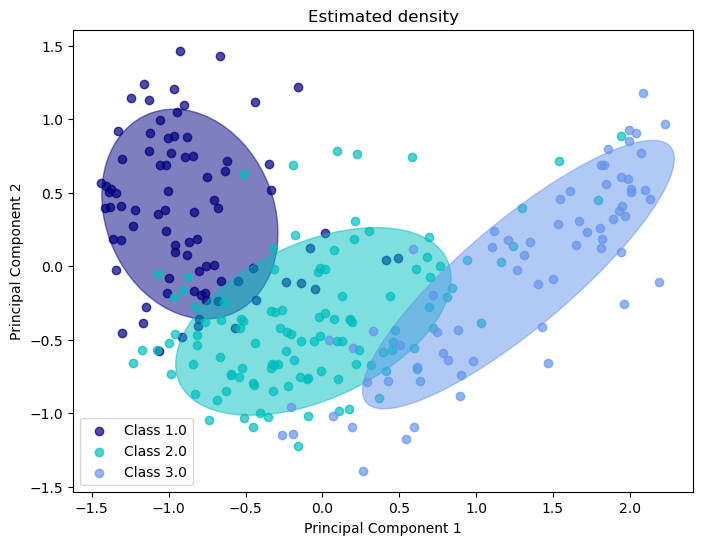

In [51]:
X= pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
Y_= np.array(orientation.values)
valid_indices = ~pd.isna(Y_)
X = X[valid_indices]
Y_ = Y_[valid_indices]
title= 'Estimated density'
# Compute means and covariances for each class
means = []
covariances = []

for cls in np.unique(Y_):
    subset = X[Y_ == cls]
    means.append(subset.mean().values)
    covariances.append(subset.cov().values)

means = np.array(means)  # Convert to numpy array
covariances = np.array(covariances)  # Convert to numpy array


plot_density_estimation_results_(
    X= X,
    Y_= Y_,
    means= means,
    covariances= covariances,
    title= title)

(10, 52)


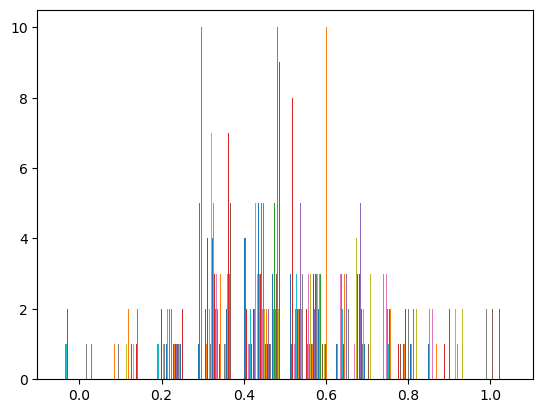

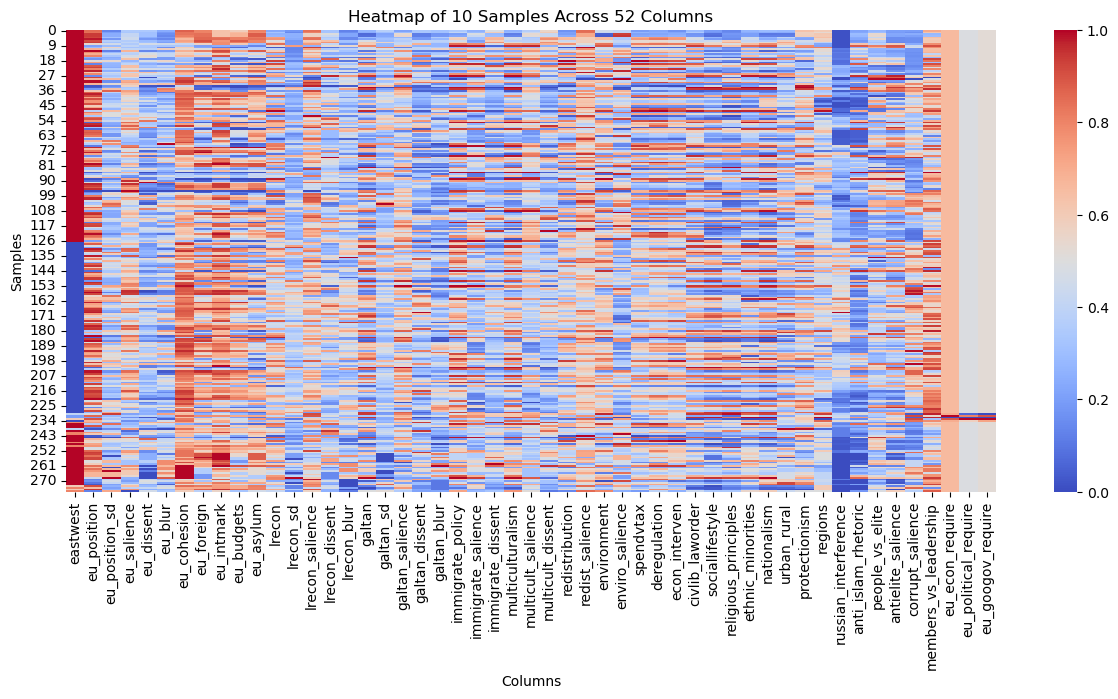

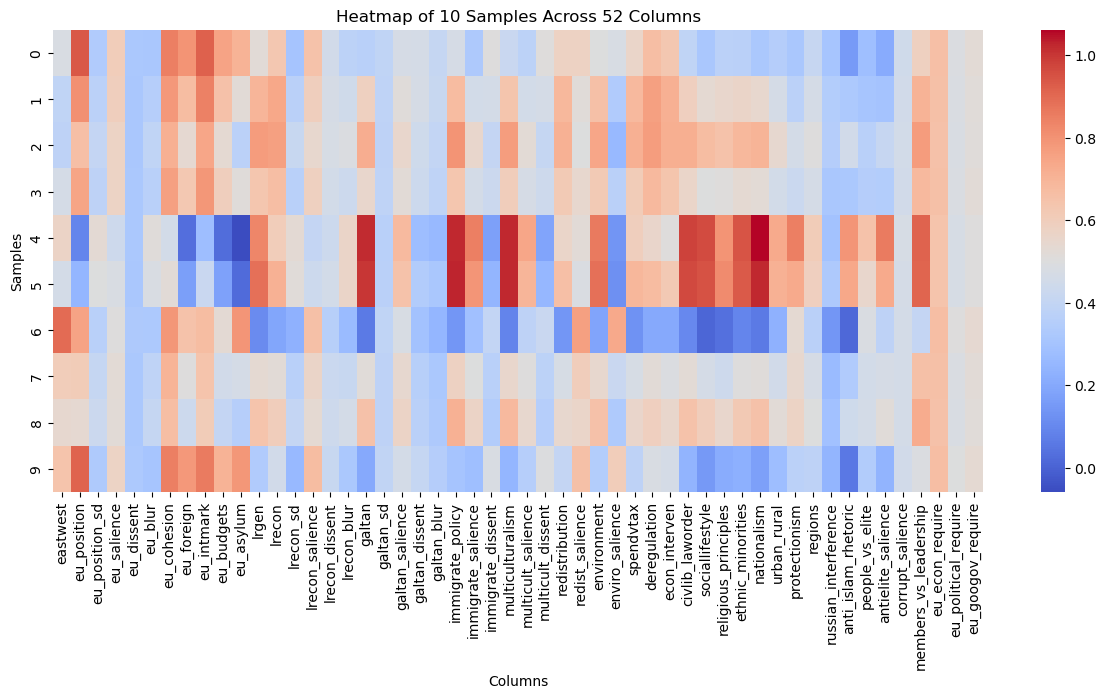

In [52]:
recovered_parties= dimensionality_red.map_to_original_space(sampled_parties)
print(recovered_parties.shape)

plt.hist(pd.DataFrame(recovered_parties, columns= df_original.columns))
plt.show()


def heatmap_viz(df: pd.DataFrame):
    df_num= df.select_dtypes(include=['number'])
    plt.figure(figsize=(15, 6))
    sns.heatmap(df_num, cmap="coolwarm", annot=False)
    plt.title("Heatmap of 10 Samples Across 52 Columns")
    plt.xlabel("Columns")
    plt.ylabel("Samples")
    plt.show()


heatmap_viz(df)
heatmap_viz(pd.DataFrame(recovered_parties, columns= df_original.columns))

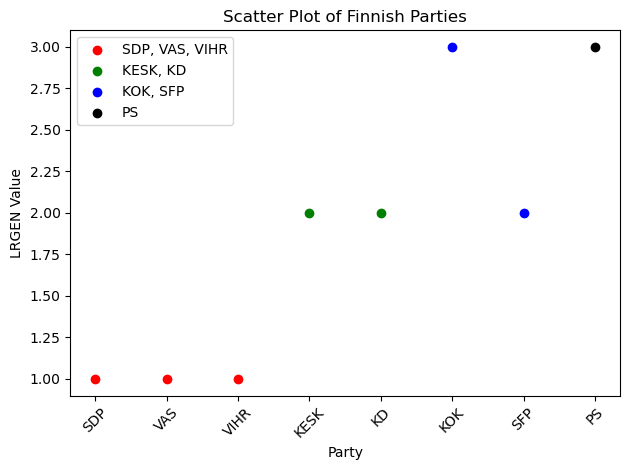

In [53]:
df_orientation= pd.DataFrame(data= orientation)
# # df_orientation.to_csv('parties.csv')
# df_orientation.index

# def plot_finnish_parties(transformed_data: pd.DataFrame, splot: plt.Axes = None):
#     """
#     Plots Finnish parties on a 2D scatter plot based on their coordinates and lrgen values.
#     """
#     finnish_parties = [
#         {"parties": ["SDP", "VAS", "VIHR"], "country": "fin", "color": "r"},
#         {"parties": ["KESK", "KD"], "country": "fin", "color": "g"},
#         {"parties": ["KOK", "SFP"], "country": "fin", "color": "b"},
#         {"parties": ["PS"], "country": "fin", "color": "k"},
#     ]

#     # If no subplot is provided, create a new one
#     if splot is None:
#         _, splot = plt.subplots()

#     # Loop through each group of Finnish parties
#     for group in finnish_parties:
#         parties = group["parties"]
#         country = group["country"]
#         color = group["color"]

#         # Filter data for the specified parties and country
#         filtered_data = transformed_data.loc[
#             (transformed_data.index.get_level_values('party').isin(parties)) &
#             (transformed_data.index.get_level_values('country') == country)
#         ]

#         # Plot the filtered data
#         splot.scatter(
#             filtered_data.index.get_level_values('party'),  # X-axis: party names
#             filtered_data['lrgen'],  # Y-axis: lrgen values
#             color=color,
#             label=", ".join(parties),
#         )

#     # Add labels, legend, and title
#     splot.set_xlabel("Party")
#     splot.set_ylabel("LRGEN Value")
#     splot.legend()
#     splot.set_title("Scatter Plot of Finnish Parties")

#     # Display the plot
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

# Call the function with the provided data
# plot_finnish_parties(pd.DataFrame(data= orientation))
# plot_finnish_parties(df)
df_orientation.index= df_original.index
plot_finnish_parties(df_orientation)

In [54]:
# # Assuming `features` is a DataFrame or NumPy array with your data
# # and `targets` is a NumPy array or Series containing class labels.

# # Replace these with your actual data
# # Example: features = pd.DataFrame(...), targets = np.array(...)
# features = np.random.rand(100, 20)  # Example data: 100 samples, 20 features
# targets = np.random.randint(0, 10, size=100)  # Example targets: 10 classes

# # Convert features to a NumPy array if it's not already
# if isinstance(features, pd.DataFrame):
#     features = features.values

# # Use PyMDE to reduce to 2D
# mde = pymde.preserve_neighbors(features, embedding_dim=2)  # Preserve neighborhood structure
# embedding = mde.embed()

# # Create a scatter plot
# plt.figure(figsize=(10, 8))
# colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Generate a color map for 10 classes

# for class_label in np.unique(targets):
#     plt.scatter(
#         embedding[targets == class_label, 0],  # X-coordinates
#         embedding[targets == class_label, 1],  # Y-coordinates
#         label=f"Class {class_label}",
#         color=colors[class_label],
#         alpha=0.7,
#         edgecolor="k"
#     )

# plt.title("2D Visualization of Features")
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")
# plt.legend()
# plt.grid(True)
# plt.show()
# 
# # import pymde
# # Example: features = pd.DataFrame(...), targets = np.array(...)
# features = df.drop(['Orientation'], axis=1)  # Example data: 100 samples, 20 features
# targets = orientation.values # Example targets: 10 classes

# # Convert features to a NumPy array if it's not already
# if isinstance(features, pd.DataFrame):
#     features = features.values

# # Use PyMDE to reduce to 2D
# mde = pymde.preserve_neighbors(features, embedding_dim=2)  # Preserve neighborhood structure
# embedding = mde.embed()

# # Create a scatter plot
# plt.figure(figsize=(10, 8))
# colors = plt.cm.tab10(np.linspace(0, 1, 3))  # Generate a color map for 10 classes

# for class_label in np.unique(targets):
#     plt.scatter(
#         embedding[targets == class_label, 0],  # X-coordinates
#         embedding[targets == class_label, 1],  # Y-coordinates
#         label=f"Class {class_label}",
#         color=colors[class_label],
#         alpha=0.7,
#         edgecolor="k"
#     )

# plt.title("2D Visualization of Features")
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")
# plt.legend()
# plt.grid(True)
# plt.show()